# An evaluation of NLG metrics


In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('src')

import os
import pandas as pd
import numpy as np
import data_utils
import matplotlib.pyplot as plt
import seaborn as sns
import metrics
import sklearn
import sklearn.cluster
import sklearn.decomposition
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
import scipy.stats
import xgboost
import optuna

os.environ.setdefault("TOKENIZERS_PARALLELISM", "true") # For huggingface
sns.set()


In [3]:
OUTPUT_DIR = "data/figs"
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)


def savefig(name: str, **kwargs):
    plt.savefig(
        f"{OUTPUT_DIR}/{name}.pdf", bbox_inches="tight", transparent=True, **kwargs
    )


## WMT 2020 Data

In [4]:
data = data_utils.load_data()
data.head()


,system,seg_id,source,target,mqm_avg_score,da_score,ref_A,ref_A_mqm_score,ref_B,ref_B_mqm_score,ref_P,ref_P_mqm_score
0,eTranslation.737,1,Michael Jackson wore tape on his nose to get f...,"Michael Jackson trug Klebeband auf der Nase, u...",-2.333333,NaN,Ehemaliger Bodyguard berichtet: Michael Jackso...,-0.0,"Ehemaliger Bodyguard behauptet, Michael Jackso...",-0.333333,"Um es aufs Cover zu schaffen, habe Michael Jac...",-2.333333
1,Huoshan_Translate.832,1,Michael Jackson wore tape on his nose to get f...,"Michael Jackson trug Klebeband auf der Nase, u...",-2.666667,NaN,Ehemaliger Bodyguard berichtet: Michael Jackso...,-0.0,"Ehemaliger Bodyguard behauptet, Michael Jackso...",-0.333333,"Um es aufs Cover zu schaffen, habe Michael Jac...",-2.333333
2,Online-A.1574,1,Michael Jackson wore tape on his nose to get f...,"Michael Jackson trug Klebeband auf der Nase, u...",-2.666667,96.333333,Ehemaliger Bodyguard berichtet: Michael Jackso...,-0.0,"Ehemaliger Bodyguard behauptet, Michael Jackso...",-0.333333,"Um es aufs Cover zu schaffen, habe Michael Jac...",-2.333333
3,Online-B.1590,1,Michael Jackson wore tape on his nose to get f...,"Michael Jackson trug Klebeband auf der Nase, u...",-2.666667,NaN,Ehemaliger Bodyguard berichtet: Michael Jackso...,-0.0,"Ehemaliger Bodyguard behauptet, Michael Jackso...",-0.333333,"Um es aufs Cover zu schaffen, habe Michael Jac...",-2.333333
4,OPPO.1535,1,Michael Jackson wore tape on his nose to get f...,"Michael Jackson trug Klebeband auf der Nase, u...",-2.666667,NaN,Ehemaliger Bodyguard berichtet: Michael Jackso...,-0.0,"Ehemaliger Bodyguard behauptet, Michael Jackso...",-0.333333,"Um es aufs Cover zu schaffen, habe Michael Jac...",-2.333333


First, we extract the candidates and references from the data frame:

In [5]:
candidates = data.target.tolist()
references = data[["ref_A", "ref_B", "ref_P"]].to_numpy().tolist()

print("First candidate:", candidates[0], sep="\n  ")
print("Corresponding references:", *references[0], sep="\n  ")


First candidate:
  Michael Jackson trug Klebeband auf der Nase, um Titelseiten zu bekommen, behauptet ehemaliger Bodyguard
Corresponding references:
  Ehemaliger Bodyguard berichtet: Michael Jackson trug Klebeband auf seiner Nase, um auf die Titelseiten zu kommen
  Ehemaliger Bodyguard behauptet, Michael Jackson trug Pflaster auf der Nase, um in die Presse zu kommen
  Um es aufs Cover zu schaffen, habe Michael Jackson sein Riechorgan mit Klebestreifen versehen, so ein einstiger Leibwächter.


Next, we extract only the references which have a score greater than -1 (a score of -1 is equivalent to one minor error):

In [6]:
idxs_filt = []
candidates_filt = []
references_filt = []
for idx, row in data.iterrows():
    refs = []
    for human in "A", "B", "P":
        if row[f"ref_{human}_mqm_score"] > -1:
            refs.append(row[f"ref_{human}"])
    if refs:
        references_filt.append(refs)
        candidates_filt.append(row["target"])
        idxs_filt.append(idx)

data_filt = data.iloc[idxs_filt]

print("First candidate:", candidates_filt[0], sep="\n  ")
print("Corresponding references:", *references_filt[0], sep="\n  ")


First candidate:
  Michael Jackson trug Klebeband auf der Nase, um Titelseiten zu bekommen, behauptet ehemaliger Bodyguard
Corresponding references:
  Ehemaliger Bodyguard berichtet: Michael Jackson trug Klebeband auf seiner Nase, um auf die Titelseiten zu kommen
  Ehemaliger Bodyguard behauptet, Michael Jackson trug Pflaster auf der Nase, um in die Presse zu kommen


## Evaluation of the dataset using automatic evaluation metrics

This evaluation is cached, and the results for the data and models we're using have been commited to git, so the following cells should run quickly.

In [7]:
m = metrics.evaluate_all(candidates, references, batch_size=1)
metrics_normal = m.columns.tolist()

m.head()


,bleu,chrf,rouge,ter,meteor,moverscore,bertscore,baryscore
0,0.452677,71.395594,0.733333,42.0,0.645236,0.689006,0.931161,0.262899
1,0.452274,62.405260,0.562500,60.0,0.535343,0.625638,0.910244,0.305000
2,0.452274,67.662048,0.645161,54.0,0.603856,0.676823,0.928487,0.221799
3,0.452274,59.576021,0.562500,60.0,0.535343,0.617522,0.909932,0.309876
4,0.452274,62.405260,0.562500,60.0,0.535343,0.625638,0.910244,0.305000


In [8]:
m_filt = metrics.evaluate_all(candidates_filt, references_filt, batch_size=1)
m_filt.set_index(np.array(idxs_filt), inplace=True)
m_filt.rename(lambda col: f"{col}_filt", axis=1, inplace=True)
metrics_filt = m_filt.columns.tolist()

m_filt.head()


,bleu_filt,chrf_filt,rouge_filt,ter_filt,meteor_filt,moverscore_filt,bertscore_filt,baryscore_filt
0,0.452677,71.395594,0.733333,43.75,0.645236,0.689015,0.931161,0.262899
1,0.443972,62.405260,0.562500,62.50,0.535343,0.626687,0.910244,0.305000
2,0.452274,67.662048,0.645161,56.25,0.603856,0.677926,0.928487,0.221799
3,0.443972,59.576021,0.562500,62.50,0.535343,0.618497,0.909932,0.309876
4,0.443972,62.405260,0.562500,62.50,0.535343,0.626687,0.910244,0.305000


In [9]:
full_data = pd.concat([data, m, m_filt], axis=1)
metrics_all = metrics_normal + metrics_filt

full_data.head(2)

,system,seg_id,source,target,mqm_avg_score,da_score,ref_A,ref_A_mqm_score,ref_B,ref_B_mqm_score,...,bertscore,baryscore,bleu_filt,chrf_filt,rouge_filt,ter_filt,meteor_filt,moverscore_filt,bertscore_filt,baryscore_filt
0,eTranslation.737,1,Michael Jackson wore tape on his nose to get f...,"Michael Jackson trug Klebeband auf der Nase, u...",-2.333333,NaN,Ehemaliger Bodyguard berichtet: Michael Jackso...,-0.0,"Ehemaliger Bodyguard behauptet, Michael Jackso...",-0.333333,...,0.931161,0.262899,0.452677,71.395594,0.733333,43.75,0.645236,0.689015,0.931161,0.262899
1,Huoshan_Translate.832,1,Michael Jackson wore tape on his nose to get f...,"Michael Jackson trug Klebeband auf der Nase, u...",-2.666667,NaN,Ehemaliger Bodyguard berichtet: Michael Jackso...,-0.0,"Ehemaliger Bodyguard behauptet, Michael Jackso...",-0.333333,...,0.910244,0.305000,0.443972,62.405260,0.562500,62.50,0.535343,0.626687,0.910244,0.305000


## Evaluation of the metrics

### Correlation between the metrics

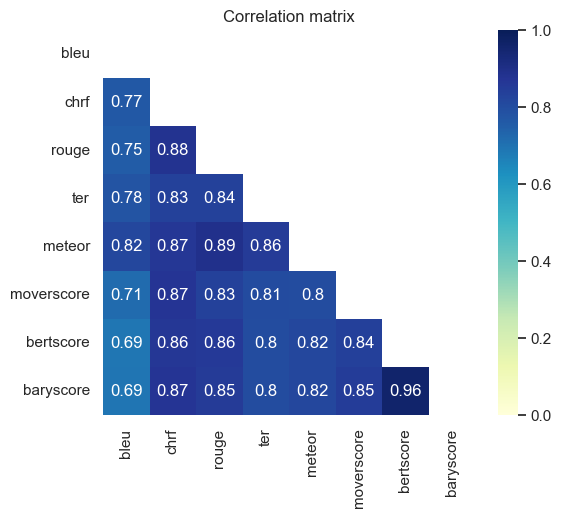

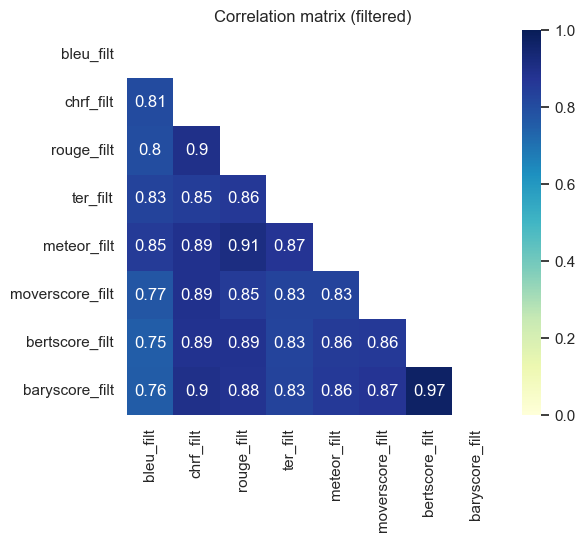

In [10]:
corr_mat = np.abs(full_data[metrics_all].corr())
mask = np.triu(np.ones_like(corr_mat.loc[metrics_normal, metrics_normal], dtype=bool))

with sns.axes_style(style="white"):
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        corr_mat.loc[metrics_normal, metrics_normal],
        mask=mask,
        cmap="YlGnBu",
        vmin=0,
        vmax=1,
        annot=True,
    )
    savefig("correlation_matrix_normal")
    plt.title("Correlation matrix")

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        corr_mat.loc[metrics_filt, metrics_filt],
        mask=mask,
        cmap="YlGnBu",
        vmin=0,
        vmax=1,
        annot=True,
    )
    savefig("correlation_matrix_filtered")
    plt.title("Correlation matrix (filtered)")


Text(0.5, 1.0, 'Correlation matrix between filtered and non-filtered metrics')

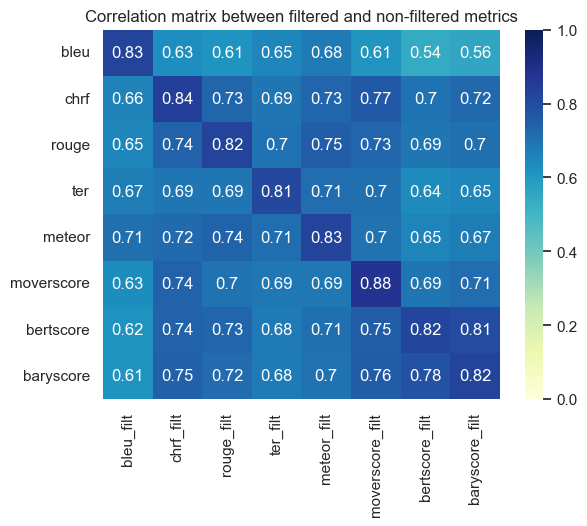

In [11]:
sns.heatmap(corr_mat.loc[metrics_normal, metrics_filt], cmap="YlGnBu", vmin=0, vmax=1, annot=True)
savefig("correlation_normal_filt")
plt.title("Correlation matrix between filtered and non-filtered metrics")

### Correlation with human scores

### Correlation with error types

### Explaining MQM with automatic metrics

### Predicting MQM with automatic metrics

In [12]:
X = full_data.loc[:, metrics_normal]
y = full_data.loc[:, 'mqm_avg_score']

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

tau score: 0.34678153273466544


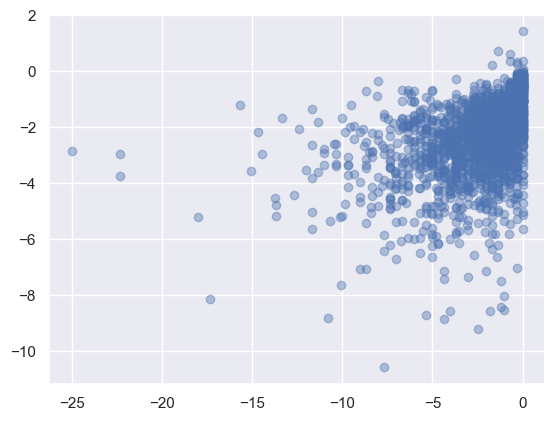

In [13]:
xgb_regressor = xgboost.XGBRegressor(random_state=42)
xgb_regressor.fit(X_train, y_train)

y_pred = xgb_regressor.predict(X_test)

print(f"tau score: {scipy.stats.kendalltau(y_test, y_pred)[0]}")

plt.scatter(y_test, y_pred, alpha=0.4)

##### Optimize model hyperparameters

In [13]:
def optimize(trials : optuna.Trial):
    params = {
        'n_estimators' : trials.suggest_int("n_estimators", 1, 500),
        'learning_rate' : trials.suggest_float("learning_rate", 0, 1),
        'min_split_loss' : trials.suggest_float("min_split_loss", 0, 10),
        'max_depth' : trials.suggest_int("max_depth", 1, 30),
        'subsample' : trials.suggest_float("subsample", 0, 1),
        'reg_lambda' : trials.suggest_float("reg_lambda", 0, 5),
        'reg_alpha' : trials.suggest_float("reg_alpha", 0, 5),
        'grow_policy' : trials.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'verbosity' : 0,
        'nthread' : 8
    }
    def kendall_score(y_true, y_pred):
        return scipy.stats.kendalltau(y_true, y_pred)[0]

    kf = sklearn.model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
    reg_xgboost = xgboost.XGBRegressor(**params)
    scores = sklearn.model_selection.cross_val_score(reg_xgboost, X_train, y_train, cv=kf, scoring=sklearn.metrics.make_scorer(kendall_score))
    return np.mean(scores)


In [14]:
study = optuna.create_study(sampler=optuna.samplers.TPESampler(multivariate=True), direction='maximize')
study.optimize(optimize, n_trials=100)
print(study.best_params, study.best_value)


#### compare model

In [14]:
xgboost_params = {
    'n_estimators': 364, 
    'learning_rate': 0.036631422567591006,
    'min_split_loss': 0.1527162494419042,
    'max_depth': 24,
    'subsample': 0.568555379762411,
    'reg_lambda': 3.9318045624725553,
    'reg_alpha': 1.0475319844544235,
    'grow_policy': 'lossguide'
}

In [17]:
reg_xgboost = xgboost.XGBRegressor(**xgboost_params)
reg_xgboost.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy='lossguide',
             importance_type=None, interaction_constraints=None,
             learning_rate=0.036631422567591006, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=24, max_leaves=None,
             min_child_weight=None, min_split_loss=0.1527162494419042,
             missing=nan, monotone_constraints=None, n_estimators=364,
             n_jobs=None, num_parallel_tree=None, predictor=None, ...)

In [16]:
y_pred = reg_xgboost.predict(X_test)

print(scipy.stats.kendalltau(y_test, y_pred)[0])


plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([-25,0], [-25,0], color='red', zorder=0)

NotFittedError: need to call fit or load_model beforehand

In [1]:
print(f'pearson : {scipy.stats.pearsonr(y_test, y_pred)[0]}')
print(f'spearman : {scipy.stats.spearmanr(y_test, y_pred)[0]}')
print(f'kendalltau : {scipy.stats.kendalltau(y_test, y_pred)[0]}')

NameError: name 'scipy' is not defined